In [1]:
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import pickle
from lxml.html import fromstring
from collections import Counter
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
import sys
import pymongo
from pymongo import MongoClient
from newspaper import Article
import json
from string import digits
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.stem.porter import *
from collections import Counter 
from nltk.corpus import wordnet # To get words in dictionary with their parts of speech
from nltk.stem import WordNetLemmatizer # lemmatizes word based on it's parts of speech
from nltk.corpus import stopwords 
from textblob import TextBlob
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import cmudict
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from sklearn.metrics.pairwise import cosine_similarity
from numpy import dot
from numpy.linalg import norm
from scipy.stats import skew
import math
from langdetect import detect
import gensim
sys.path.append("/Users/rohanramesh/Documents/GitHub/Insight_writers/lib/")
from text_processing import ProcessArticle as pa
import suggestions as s

In [95]:
# data load from muckrack
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/Attempt4_mr_scrape.pickle', 'rb') as handle:
    scrapevar = pickle.load(handle)
    
# load writer df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_df.pickle', 'rb') as handle:
    writer_df = pickle.load(handle)

In [96]:
writer_df.head()

,Wikisurvey ID,Idea ID,Idea Text,Wins,Losses,Times involved in Cant Decide,Score,User Submitted,Session ID,Created at,Last Activity,Active,Appearances on Left,Appearances on Right,Info,website_name
0,11361,693716,Zach Lowe,2951,288,100,91.0830,False,5012316,2017-09-13 15:28:25 UTC,2017-10-03 01:44:17 UTC,True,1821,1908,NaN,zachlowe_nba
1,11361,693715,Adrian Wojnarowski,2457,732,118,77.0291,False,5012316,2017-09-13 15:28:25 UTC,2017-10-03 01:40:16 UTC,True,1855,1835,NaN,adrian-wojnarowski
2,11361,693742,Lee Jenkins,2421,746,260,76.4279,False,5012316,2017-09-13 15:28:26 UTC,2017-10-03 01:43:04 UTC,True,1917,1841,NaN,lee-jenkins
3,11361,693755,Howard Beck,2425,748,186,76.4094,False,5012316,2017-09-13 15:28:26 UTC,2017-10-03 01:44:13 UTC,True,1839,1864,NaN,howardbeck
4,11361,693719,Marc Stein,2426,759,120,76.1531,False,5012316,2017-09-13 15:28:26 UTC,2017-10-03 01:44:11 UTC,True,1788,1898,NaN,marc-stein


In [3]:
# Establish connection with database
client = MongoClient()
# mydb = client["testinsightdb"]
mydb = client["insightwriterdb"]

In [58]:
# detect if no english and return a flag
def detect_nonenglish(txtstr):
    b = sent_tokenize(txtstr)
    b = b[0:np.max([10,len(b)])] # take longest of first 10 sentences
    # n words per sentence
    nwords = [len(word_tokenize(i)) for i in b]
    if not nwords:
        output = True
    else:
        idx = nwords.index(np.max(nwords))
        c = detect(b[idx])
        if c != 'en':
            output = True
        else:
            output = False
    return output

In [29]:
token_dist = []
for curr_name in writer_df['website_name']:
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    ninsample = y.count()
    article_idx_to_sample = random.sample(range(0,ninsample), np.min([ninsample,300]))
    # for saving tokens for later - compile across all articles included
#     all_tokens_by_author[curr_name] = []
    for i in article_idx_to_sample:
        tokens = word_tokenize(y[i]['article'])
        token_dist.append(len(tokens))

/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """


In [79]:
# lets build corpus of all writers sampling 10 articles from each author
def build_corpus_delta_method(authors, npieces_sample, mydb, nwords_sample=None):
    t = time.time()
    # authors = ['zachlowe_nba', 'marc-stein', 'howard-beck']

    # Combine every paper except our test case into a single corpus
    whole_corpus = []
    all_tokens_by_author = {}
    for curr_name in authors:
        currcol = mydb[curr_name]
        y = currcol.find({"name": curr_name})
        ninsample = y.count()
        article_idx_to_sample = random.sample(range(0,ninsample), np.min([ninsample,npieces_sample]))
        # for saving tokens for later - compile across all articles included
        all_tokens_by_author[curr_name] = []
        for i in article_idx_to_sample:
            a = detect_nonenglish(y[i]['article'])
            if a == True:
                continue
            tokens = word_tokenize(y[i]['article'])
            # Filter out punctuation
            no_punct_tokens = ([token for token in tokens 
                                                    if any(c.isalpha() for c in token)])
            if nwords_sample is not None:
                try: 
                    aaa = np.random.choice(no_punct_tokens, nwords_sample, replace=True)
                    no_punct_tokens = list(aaa)
                except:
                    print(curr_name)
            all_tokens_by_author[curr_name] += no_punct_tokens
            whole_corpus += no_punct_tokens

    # Get a frequency distribution
    whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(30))
    whole_corpus_freq_dist[ :10 ]

    # The main data structure
    features = [word for word,freq in whole_corpus_freq_dist]
    feature_freqs = {}

    for curr_name in authors:
        # A dictionary for each candidate's features
        feature_freqs[curr_name] = {} 

    #     # A helper value containing the number of tokens in the author's subcorpus
        overall = len(all_tokens_by_author[curr_name])
        if overall == 0:
            overall = 1

        # Calculate each feature's presence in the subcorpus
        for feature in features:
            presence = all_tokens_by_author[curr_name].count(feature)
            feature_freqs[curr_name][feature] = presence / overall

    # The data structure into which we will be storing the "corpus standard" statistics
    corpus_features = {}

    # For each feature...
    for feature in features:
        # Create a sub-dictionary that will contain the feature's mean 
        # and standard deviation
        corpus_features[feature] = {}

        # Calculate the mean of the frequencies expressed in the subcorpora
        feature_average = 0
        for curr_name in authors:
            feature_average += feature_freqs[curr_name][feature]
        feature_average /= len(authors)
        corpus_features[feature]["Mean"] = feature_average

        # Calculate the standard deviation using the basic formula for a sample
        feature_stdev = 0
        for curr_name in authors:
            diff = feature_freqs[curr_name][feature] - corpus_features[feature]["Mean"]
            feature_stdev += diff*diff
        feature_stdev /= (len(authors) - 1)
        feature_stdev = math.sqrt(feature_stdev)
        corpus_features[feature]["StdDev"] = feature_stdev

    feature_zscores = {}
    for curr_name in authors:
        feature_zscores[curr_name] = {}
        for feature in features:

            # Z-score definition = (value - mean) / stddev
            # We use intermediate variables to make the code easier to read
            feature_val = feature_freqs[curr_name][feature]
            feature_mean = corpus_features[feature]["Mean"]
            feature_stdev = corpus_features[feature]["StdDev"]
            feature_zscores[curr_name][feature] = ((feature_val-feature_mean) / 
                                                feature_stdev)
    return feature_zscores, corpus_features, features
    elapsed = time.time() - t
    print(elapsed)
    
# get delta values for a given test case
def get_delta_values(feature_zscores, corpus_features, features, article, authors):
    # tokenize
    testcase_tokens = word_tokenize(article)

    # Filter out punctuation and lowercase the tokens
    testcase_tokens = [token.lower() for token in testcase_tokens 
                       if any(c.isalpha() for c in token)]

    # Calculate the test case's features
    overall = len(testcase_tokens)
    if overall == 0:
        overall = 1
    testcase_freqs = {}
    for feature in features:
        presence = testcase_tokens.count(feature)
        testcase_freqs[feature] = presence / overall

    # Calculate the test case's feature z-scores
    testcase_zscores = {}
    for feature in features:
        feature_val = testcase_freqs[feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    #     print("Test case z-score for feature", feature, "is", testcase_zscores[feature])

    author_deltas = []
    for author in authors:
        delta = 0
        for feature in features:
            delta += math.fabs((testcase_zscores[feature] - 
                                feature_zscores[author][feature]))
        delta /= len(features)
    #     print( "Delta score for candidate", author, "is", delta )
        author_deltas.append(delta)

    output_df = pd.DataFrame.from_dict({'deltas': author_deltas, "author_list": authors})
    return output_df

In [73]:
author_list = list(set(writer_feature_df['author_list']))
feature_zscores, corpus_features, features = build_corpus_delta_method(author_list, 300, mydb, 1000)

/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if sys.path[0] == '':


In [76]:
feature_zscores.keys()

dict_keys(['austin-hutchinson', 'adrian-wojnarowski', 'alex-kennedy', 'chris_broussard', 'jared-zwerling', 'tom-haberstroh', 'ramona-shelburne', 'paul-flannery', 'holly-mackenzie', 'michael-lee', 'derek-bodner', 'jeff-siegel', 'brady-klopfer', 'robmahoney', 'israel-gutierrez', 'christian-rivas', 'ian-begley', 'sam_amick', 'nate-duncan', 'andrew-sharp', 'scott-rafferty', 'joshrobbins', 'krishna-narsu', 'zach-harper', 'chris-mannix', 'showardcooper', 'jason-concepcion', 'adam-mares', 'mike-brady', 'justin-willard', 'dennis-chambers', 'ben-rohrbach', 'mike-prada', 'austin-green', 'skip-bayless', 'thompsonscribe', 'chris-vernon', 'billsimmons', 'jpdabrams', 'trevor-magnotti', 'noah-torr', 'dan-devine', 'frank-isola', 'beckley-mason', 'chris-ballard', 'howardbeck', 'brian-windhorst', 'rob-lopez', 'timkawakami', 'bobby-marks', 'marc-stein', 'ben-golliver', 'josh-eberley', 'kacy-sager', 'mark-deeks', 'ben-falk', 'david-thorpe', 'royce-webb', 'michael-grange', 'britt-robson', 'shams-charania',

In [94]:
# test_instance = random.sample(authors,1)[0]
test_instance = 'lee-jenkins'
currcol = mydb[test_instance]
y = currcol.find({"name": test_instance})
ninsample = y.count()
article_idx_to_sample = random.sample(range(0,ninsample), 1)
article = y[article_idx_to_sample[0]]['article']
a = get_delta_values(feature_zscores, corpus_features, features, article, author_list)
idx = a['author_list'] == test_instance
print(a[idx])
a.sort_values(by='deltas').head()

      deltas  author_list
73  1.098724  lee-jenkins


/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """


,deltas,author_list
73,1.098724,lee-jenkins
31,1.146356,ben-rohrbach
44,1.176558,chris-ballard
41,1.176971,dan-devine
20,1.204105,scott-rafferty


In [268]:
# iterate through each article collect all deltas and save in list to look at truth for comps
author_similarity_delta = {}
for curr_name in author_list:
    author_similarity_delta[curr_name] = []
    # curr_name = 'zachlowe_nba'
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    across_articles_delta = []
    for curr_art in y: 
        # curr_art = y[1]
        outputdf = get_delta_values(feature_zscores, corpus_features, curr_art['article'])
        curr_delta_sim = [] # for this article
        for name_comp in author_list:
            idx = outputdf['author_list'] == name_comp
            r = outputdf['deltas'][idx].tolist()
            curr_delta_sim.append(r[0])
        across_articles_delta.append(curr_delta_sim)
    author_similarity_delta[curr_name].append(across_articles_delta)

In [278]:
np.shape(author_similarity_delta['zachlowe_nba'][0])[0]

400

In [300]:
deltas_authors_v_authors = np.ndarray(shape=(len(author_list),len(author_list)))
for r in range(0,len(author_list)):
    curr_name = author_list[r]
    narticles = np.shape(author_similarity_delta[curr_name][0])[0]
    # these are all articles
#     sim_to_author = []
    for i in range(0,len(author_list)):
        curr_art_sim = []
        for curr_art_n in range(0,narticles):
            curr_art_sim.append(author_similarity_delta[curr_name][0][curr_art_n][i])
        deltas_authors_v_authors[r,i] = np.mean(curr_art_sim)
    #     sim_to_author.append(np.median(curr_art_sim))

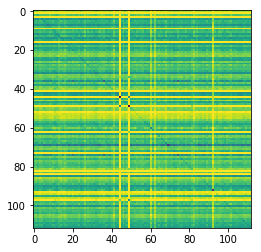

In [302]:
# tmp_df = pd.DataFrame.from_dict({'sim': sim_to_author, 'auth': author_list})
# tmp_df.sort_values(by='sim').head(10)
plt.imshow(deltas_authors_v_authors)
plt.clim(0,3)

In [21]:
# add some basic features for each article
mongo_id = []
n_words = []
n_sentences = []
n_wordspersentence = []
n_word_sent_var = []
author_list = []
author_id_n = []
n_nouns = []
n_adj = []
n_verb = []
n_adv =[]
wordlength = []
wordlength_var = []
wordlength_skew = []
# for additional authors from sight list
authors_from_site = []
authors_from_mr = []
# for sentiment analysis
analyzer = SentimentIntensityAnalyzer()
avg_sentim = []
sentim_var = []
# iterate over all writers
for ii in range(0,np.shape(writer_df)[0]):
    #     curr_name in writer_df['website_name']
    curr_name = writer_df['website_name'][ii]
    curr_name_full = writer_df['Idea Text'][ii]
    print(curr_name)
    t = time.time()
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    for curr_art in y:
        a = detect_nonenglish(curr_art['article'])
        if a == True:
            continue
        # mongo id number
        mongo_id.append(str(curr_art['_id']))
        # authors from sits
        authors_from_site.append(curr_art['authors'])
        authors_from_mr.append(curr_name_full)
        # n words after cleaning and removing numbers and punctuation
        curr = pa(curr_art['article'])
        curr.clean_text()
    #     cleantext = clean_text(curr_art['article'])
        n_words.append(curr.get_nwords())
        # n sentences
        ns, nw_s, nw_s_var = curr.get_nsentences()
        n_sentences.append(ns)
        n_wordspersentence.append(nw_s)
        n_word_sent_var.append(nw_s_var)
        # author list
        author_list.append(curr_name)
        # author id n
        author_id_n.append(curr_art['writer_id'])
        # remove stopwords from story
        aa = curr.get_pos_article()
        n_nouns.append(aa[0])
        n_adj.append(aa[1])
        n_verb.append(aa[2])
        n_adv.append(aa[3])
        # get word info
        curr_wordlength, curr_wordlength_var, curr_wordlength_skew = curr.get_word_length()
        wordlength.append(curr_wordlength)
        wordlength_var.append(curr_wordlength_var)
        wordlength_skew.append(curr_wordlength_skew)
        aa = curr.get_sentiments_of_sentences()
        # take avg sentim for each story by averaging sentim for each sentence
        avg_sentim.append([aa[0][0][0], aa[0][0][1], aa[0][0][2], aa[0][0][3]])
        # take std of sentim for each story to measure sentiment variability
        sentim_var.append([aa[1][0][0], aa[1][0][1], aa[1][0][2], aa[1][0][3]])
    elapsed = time.time() - t
    print(elapsed)

zachlowe_nba
86.40087795257568
adrian-wojnarowski
18.118824005126953
lee-jenkins
37.053638219833374
howardbeck
42.97023606300354
marc-stein
32.9446439743042
ethan-sherwood-strauss
18.524333238601685
jason-concepcion
40.26346492767334
kevin-arnovitz
25.888498783111572
tom-haberstroh
19.78650712966919
nate-duncan
2.9686810970306396
zach-harper
7.6198930740356445
brian-windhorst
28.851887226104736
sam_amick
33.017675161361694
david-aldridge
74.2960376739502
ramona-shelburne
34.93025803565979
jpdabrams
32.2483389377594
kevin-pelton
35.92349410057068
marc-j-spears
47.67526602745056
matt-moore
48.30571436882019
shams-charania
23.989476203918457
kevin-p-oconnor
3.267617702484131
chris-haynes
25.36006999015808
dave-mcmenamin
31.458938121795654
shea-serrano
59.69196271896362
ian-begley
20.550609827041626
rachel-nichols
1.9729032516479492
ben-golliver
52.35324025154114
mike-prada
26.76696491241455
robmahoney
49.67922520637512
tim-macmahon
25.563719987869263
chris-herring
16.321024179458618
bills

In [27]:
# build a pd of what we have so far
data = {'n_words': n_words, 'author_id_n': author_id_n, 'author_list': author_list, 'mongo_id': mongo_id,
        'n_nouns': n_nouns, 'n_adj': n_adj, 'n_verb': n_verb, 'n_adv': n_adv, 'n_sentences': n_sentences, 
        'n_wordspersentence': n_wordspersentence, 'n_wordspersent_variability': n_word_sent_var, 
        'neg_sent': [i[0] for i in avg_sentim], 'neu_sent': [i[1] for i in avg_sentim],
        'pos_sent': [i[2] for i in avg_sentim], 'neg_sent_var': [i[0] for i in sentim_var], 
       'neu_sent_var': [i[1] for i in sentim_var], 'pos_sent_var': [i[2] for i in sentim_var], 
       'wordlength': wordlength, 'wordlength_var': wordlength_var, 'wordlength_skew': wordlength_skew, 
       'authors_from_site': authors_from_site, 'authors_from_mr': authors_from_mr}
writer_feature_df = pd.DataFrame.from_dict(data)
writer_feature_df.head()
print(np.shape(writer_feature_df))
writer_feature_df = writer_feature_df.drop_duplicates(subset='wordlength_var')
print(np.shape(writer_feature_df))

# do fractions
writer_feature_df['noun_fraction'] = writer_feature_df['n_nouns']/writer_feature_df['n_words']
writer_feature_df['adj_fraction'] = writer_feature_df['n_adj']/writer_feature_df['n_words']
writer_feature_df['adv_fraction'] = writer_feature_df['n_adv']/writer_feature_df['n_words']
writer_feature_df['verb_fraction'] = writer_feature_df['n_verb']/writer_feature_df['n_words']
writer_feature_df.head()

(27597, 22)
(23246, 22)


,n_words,author_id_n,author_list,mongo_id,n_nouns,n_adj,n_verb,n_adv,n_sentences,n_wordspersentence,...,pos_sent_var,wordlength,wordlength_var,wordlength_skew,authors_from_site,authors_from_mr,noun_fraction,adj_fraction,adv_fraction,verb_fraction
0,2966,693716,zachlowe_nba,5b9dc56f11919a056e11444d,1245,67,413,102,185,19.854054,...,0.143422,4.975468,2.747291,1.225534,"[Zach Lowe, Adrian Wojnarowski, Michael C. Wri...",Zach Lowe,0.419757,0.022589,0.034390,0.139245
2,2697,693716,zachlowe_nba,5b9dc57211919a056e11444f,1000,60,363,112,151,20.774834,...,0.123817,4.692946,2.482535,1.075665,"[Zach Lowe, Adrian Wojnarowski, Michael C. Wri...",Zach Lowe,0.370782,0.022247,0.041528,0.134594
3,2813,693716,zachlowe_nba,5b9dc57311919a056e114450,1060,58,411,86,183,18.568306,...,0.122222,4.717626,2.490510,1.088954,"[Zach Lowe, Adrian Wojnarowski, Michael C. Wri...",Zach Lowe,0.376822,0.020619,0.030572,0.146107
5,2506,693716,zachlowe_nba,5b9dc57511919a056e114452,803,68,393,63,203,15.330049,...,0.151518,4.619163,2.516590,1.135553,"[Zach Lowe, Adrian Wojnarowski, Michael C. Wri...",Zach Lowe,0.320431,0.027135,0.025140,0.156824
6,2192,693716,zachlowe_nba,5b9dc57611919a056e114453,849,44,311,76,132,19.704545,...,0.130160,4.753343,2.445443,1.056237,"[Zach Lowe, Adrian Wojnarowski, Michael C. Wri...",Zach Lowe,0.387318,0.020073,0.034672,0.141880


In [101]:
# write to postgresql database for later pulling
dbname = 'writer_feature_db'
# dbname = 'writer_db'
username = 'rohanramesh' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))
# writer_feature_df.to_sql('writer_feature', engine, if_exists='replace')

postgres://rohanramesh@localhost/writer_feature_db
True


In [102]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)

In [103]:
# query to load entire db into pandas
sql_query = """
SELECT * FROM writer_feature;
"""
writer_feature_df = pd.read_sql_query(sql_query,con)

In [105]:
writer_feature_df.head()

,level_0,index,n_words,author_id_n,author_list,mongo_id,n_nouns,n_adj,n_verb,n_adv,...,n_wordspersent_variability,neg_sent,neu_sent,pos_sent,neg_sent_var,neu_sent_var,pos_sent_var,wordlength,wordlength_var,wordlength_skew
0,0,0,2966,693716,zachlowe_nba,5b9c705c11919a2b1a15c30d,1245,67,413,102,...,17.212670,0.078108,0.839638,0.082249,0.134054,0.185814,0.143422,4.801696,2.667325,1.402407
1,1,1,2966,693716,zachlowe_nba,5b9c705d11919a2b1a15c30e,1245,67,413,102,...,17.212670,0.078108,0.839638,0.082249,0.134054,0.185814,0.143422,4.801696,2.667325,1.402407
2,2,2,2697,693716,zachlowe_nba,5b9c705f11919a2b1a15c30f,1000,60,363,112,...,16.185666,0.037828,0.869960,0.092225,0.083719,0.139230,0.123817,4.607130,2.427109,1.110728
3,3,3,2813,693716,zachlowe_nba,5b9c706011919a2b1a15c310,1060,58,411,86,...,11.751734,0.059246,0.854087,0.086639,0.106565,0.143424,0.122222,4.571527,2.405555,1.074744
4,4,4,2813,693716,zachlowe_nba,5b9c706111919a2b1a15c311,1060,58,411,86,...,11.751734,0.059246,0.854087,0.086639,0.106565,0.143424,0.122222,4.571527,2.405555,1.074744


In [304]:
#backup
writer_feature_df_backup = writer_feature_df

In [106]:
# # save writer feature df
# with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_feature_df_5.pickle', 'wb') as handle:
#     pickle.dump(writer_feature_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_feature_df_5.pickle', 'rb') as handle:
    writer_feature_df = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_feature.pickle'

In [107]:
writer_features = pd.read_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_features.pickle')


In [113]:
def match_author_names(writer_df, author):
    wa = writer_df['website_name'].tolist()
    al = writer_df['Idea Text'].tolist()
    if author in wa:
        return al[wa.index(author)]
    elif author in al:
        return wa[al.index(author)]
    else:
        print('improper author name')

In [114]:
# add column to writer_features for full name
ordered_website_names = writer_features['author_list']
full_names = []
for i in ordered_website_names:
    full_names.append(match_author_names(writer_df, i))

In [117]:
writer_features['author_fn'] = full_names
writer_features.to_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_features_USE.pickle')

In [26]:
# lets build features that will put in
# Features to include:
    # n_words
    # n_nouns/n_words
    # n_adj/n_words
    # n_verb/n_words
    # n_adv/n_words
    # n_sentences
    # n_wordspersentence
    # n_wordspersentence_variability
    # positive sentiment
    # neu sentiment
    # negative sentiment
    # positive sentiment variability
    # neu sentiment variability
    # negative sentiment variability




In [13]:
features_use = ['n_words', 'noun_fraction', 'adj_fraction', 'adv_fraction', 'verb_fraction', 
               'neg_sent', 'pos_sent', 'neu_sent', 'neg_sent_var', 'neu_sent_var', 'pos_sent_var', 
               'n_sentences', 'n_wordspersentence', 'n_wordspersent_variability', 'author_list']
writer_feature_df_2 = writer_feature_df[features_use]
writer_feature_df_2.replace([np.inf, -np.inf], np.nan)
writer_feature_df_2 = writer_feature_df_2.dropna(axis=0, how='any')
# pd.isna(writer_feature_df_2)
print(np.shape(writer_feature_df_2))

(23252, 15)


In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
input_1 = pd.DataFrame.transpose(writer_feature_df_2)
pca.fit(input_1)
# a = writer_feature_df_2['n_wordspersentence']
# a.isnull().values.any()
a = pca.components_
print(np.shape(a))
plt.plot(a[0],a[1],'o')

In [14]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=1, perplexity=30, 
                  n_iter=1000).fit_transform(writer_feature_df_2.drop('author_list', axis=1))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23252 samples in 0.018s...
[t-SNE] Computed neighbors for 23252 samples in 0.654s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23252
[t-SNE] Computed conditional probabilities for sample 2000 / 23252
[t-SNE] Computed conditional probabilities for sample 3000 / 23252
[t-SNE] Computed conditional probabilities for sample 4000 / 23252
[t-SNE] Computed conditional probabilities for sample 5000 / 23252
[t-SNE] Computed conditional probabilities for sample 6000 / 23252
[t-SNE] Computed conditional probabilities for sample 7000 / 23252
[t-SNE] Computed conditional probabilities for sample 8000 / 23252
[t-SNE] Computed conditional probabilities for sample 9000 / 23252
[t-SNE] Computed conditional probabilities for sample 10000 / 23252
[t-SNE] Computed conditional probabilities for sample 11000 / 23252
[t-SNE] Computed conditional probabilities for sample 12000 / 23252
[t-SNE] Computed conditional probabilities for sam

(23252, 2)


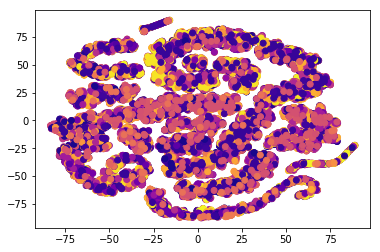

In [15]:
print(np.shape(X_embedded))
all_authors = writer_feature_df_2['author_list']
unique_authors = list(set(all_authors))
cm = plt.get_cmap('plasma_r',len(unique_authors))
cmap_colors = [cm.colors[unique_authors.index(i)] for i in all_authors]
np.shape(cm.colors)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cmap_colors[:])

In [16]:
# plot red dots for the top 5 recommendations
a = s.give_author_suggestion_from_author(writer_feature_subsection,'chris-ballard')
print(a['authors'].tolist())
cmap_colors = []
for i in all_authors:
    if i in a['authors'].tolist():
        cmap_colors.append([1,0,0])
    else:
        cmap_colors.append([0.9,0.9,0.9])
plt.scatter(X_embedded[:,0],X_embedded[:,1],s=9,c=cmap_colors[:], alpha=0.1)        
    

NameError: name 'give_author_suggestion_from_author' is not defined

In [8]:
# query
#          AVG("noun_fraction") AS "avg_noun_fraction",
#          AVG("adj_fraction") AS "avg_adj_fraction",
#          AVG("adv_fraction") AS "avg_adv_fraction",


sql_query = """
SELECT AVG("n_words") AS "avg_n_words",
         AVG("neg_sent") AS "avg_neg_sent",
         AVG("neu_sent") AS "avg_neu_sent",
         AVG("pos_sent") AS "avg_pos_sent",
         AVG("neg_sent_var") AS "avg_neg_sent_var",
         AVG("neu_sent_var") AS "avg_neu_sent_var",
         AVG("pos_sent_var") AS "avg_pos_sent_var",
        AVG("n_sentences") AS "avg_n_sentences",
        AVG("n_wordspersentence") AS "avg_n_wordspersentence",
        AVG("n_wordspersent_variability") AS "avg_n_wordspersent_variability",
        AVG("wordlength") AS "avg_wordlength",
        AVG("wordlength_var") AS "avg_wordlength_var",
        AVG("wordlength_skew") AS "avg_wordlength_skew",
        "author_list"
FROM writer_feature
WHERE "n_words" > 100
GROUP BY "author_list"
HAVING COUNT(*) > 25 
ORDER BY AVG("n_words") DESC
"""
writer_feature_subsection = pd.read_sql_query(sql_query,con)
writer_feature_subsection.head(10)
writer_feature_subsection.replace([np.inf, -np.inf], np.nan)
writer_feature_subsection = writer_feature_subsection.dropna(axis=0, how='any')

In [9]:
len(writer_feature_subsection)

80

In [10]:
# normalize
norm_writer_feature_subsection = s.normalize_df(writer_feature_subsection)

In [9]:
X_embedded = TSNE(n_components=2, 
                  verbose=1).fit_transform(norm_writer_feature_subsection.drop('author_list', axis=1))

NameError: name 'TSNE' is not defined

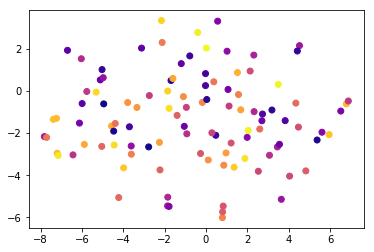

In [479]:
all_authors = writer_feature_subsection['author_list']
unique_authors = list(set(all_authors))
cm = plt.get_cmap('plasma_r',len(unique_authors))
cmap_colors = [cm.colors[unique_authors.index(i)] for i in all_authors]
np.shape(cm.colors)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cmap_colors[:])

In [11]:
# lets do all pairwise cosine similarities
nvals = np.shape(writer_feature_subsection)[0]
matsim_feat = np.ndarray(shape=(nvals,nvals))
for i in range(0,nvals):
    for j in range(0,nvals):
        vec1 = norm_writer_feature_subsection.iloc[i,:-1].values
        vec2 = norm_writer_feature_subsection.iloc[j,:-1].values
        result1 = s.cos_sim(vec1, vec2)
        matsim_feat[i, j] = result1

80
(80, 80)


Text(0,0.5,'Authors')

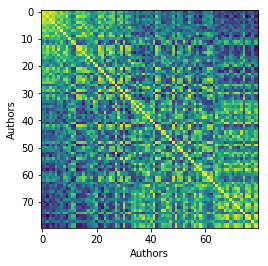

In [12]:
print(len(norm_writer_feature_subsection))
print(np.shape(matsim_feat))
plt.imshow(matsim_feat)
plt.xlabel('Authors')
plt.ylabel('Authors')

In [22]:
def give_suggestions_featurespace(matsim_feat, input_author, author_list):
    idx = author_list.index(input_author)
    tdf = pd.DataFrame.from_dict({'cos_sim': matsim_feat[idx,:], 'authors': author_list})
    a = tdf.sort_values(by='cos_sim', ascending=False)
    return a.iloc[0:5]

# go get the url
def grab_article(article_url):
    article = Article(article_url)
    article.download()
    article.parse()
    article.text
    return article

# def give_suggestion_featurespace_single_article(txtstr, means, stds, norm_feature_df):
def give_suggestion_featurespace_single_article(writer_feature_subsection, txtstr=None, url=None):
    if txtstr is not None:
        vec = build_feature_vector_for_article(txtstr)
    else:
        arti = grab_article(url)
        vec = build_feature_vector_for_article(arti.text)        
    norm_vec = normalize_vec(vec, writer_feature_subsection.mean().tolist(), 
                             writer_feature_subsection.std().tolist())
    norm_feature_df = normalize_df(writer_feature_subsection)
    authors = norm_feature_df['author_list']
    # do similarity test
    similarity_vec = []
    for i in range(0,len(authors)):
        vec1 = norm_feature_df.iloc[i,:-1].values
        result1 = cos_sim(vec1, norm_vec)
        similarity_vec.append(result1)
    tdf = pd.DataFrame.from_dict({'cos_sim': similarity_vec, 'authors': authors})
    output_df = tdf.sort_values(by='cos_sim', ascending=False)
    return output_df.iloc[0:5]
        
def give_suggestions_deltaspace(deltas_authors_v_authors, input_author, author_list):
    idx = author_list.index(input_author)
    tdf = pd.DataFrame.from_dict({'delta_sim': deltas_authors_v_authors[idx,:], 'authors': author_list})
    a = tdf.sort_values(by='delta_sim', ascending=True)
#     a['authors'][0:10]
#     print(a.head(10))
    return a.iloc[0:10]

In [24]:
# b = (writer_feature_subsection.mean().tolist())
# a = (build_feature_vector_for_article(curr_art['article']))
# c = normalize_vec(a, writer_feature_subsection.mean().tolist(), writer_feature_subsection.std().tolist())
# print(c)
arti_url = 'http://www.espn.com/nba/story/_/id/24191536/zach-lowe-jimmy-butler-blake-griffin-nba-supermax'
# arti = grab_article(arti_url)
# curr_name = 'zachlowe_nba'
# currcol = mydb[curr_name]
# y = currcol.find({"name": curr_name})
# print(y.count())
a = give_suggestion_featurespace_single_article(writer_feature_subsection, url=arti_url)
print(a)

ValueError: shapes (16,) and (13,) not aligned: 16 (dim 0) != 13 (dim 0)

In [602]:
tmp_auth_list = norm_writer_feature_subsection['author_list'].tolist()
give_suggestions_featurespace(matsim_feat, 'zachlowe_nba', tmp_auth_list)

,cos_sim,authors
7,1.000000,zachlowe_nba
2,0.886184,lee-jenkins
1,0.878062,chris-ballard
32,0.713748,howardbeck
11,0.698557,jonathan-tjarks


In [381]:
give_suggestions_deltaspace(deltas_authors_v_authors, 'lee-jenkins', author_list)

,delta_sim,authors
4,1.348194,lee-jenkins
17,1.374409,chris-ballard
1,1.447989,ian-oconnor-1027184
25,1.458531,michael-grange
7,1.480210,michael-pina
103,1.492037,adi-joseph
48,1.500533,jpdabrams
19,1.505536,ben-golliver
29,1.506141,zach-harper
23,1.512527,ethan-sherwood-strauss


In [567]:
def give_author_suggestion_from_author(writer_feature_subsection, author):
    norm_feature_df = normalize_df(writer_feature_subsection)
    authors = norm_feature_df['author_list'].tolist()
    if author not in authors:
        return 'blah'
    else:
        idx = authors.index(author)
        norm_vec = norm_feature_df.iloc[idx][:-1]
        # do similarity test
        similarity_vec = []
        for i in range(0,len(authors)):
            vec1 = norm_feature_df.iloc[i,:-1].values
            result1 = cos_sim(vec1, norm_vec)
            similarity_vec.append(round(result1*10,2)) # multiply bu 10 to scale
        tdf = pd.DataFrame.from_dict({'similarity': similarity_vec, 'authors': authors})
        output_df = tdf.sort_values(by='similarity', ascending=False)
        return output_df.iloc[0:5]

In [547]:
writer_feature_subsection.to_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_features.pickle')

In [559]:
a = give_author_suggestion_from_author(writer_feature_subsection,'lee-jenkins')

['steve-kyler', 'chris-ballard', 'lee-jenkins', 'dennis-chambers', 'jared-zwerling', 'justin-willard', 'billsimmons', 'zachlowe_nba', 'alex-kennedy', 'david-aldridge', 'shea-serrano', 'jonathan-tjarks', 'james-holas', 'michael-pina', 'mika-honkasalo', 'britt-robson', 'mark-deeks', 'robmahoney', 'dan-devine', 'kevin-pelton', 'michael-lee', 'marc-j-spears', 'ben-golliver', 'tom-haberstroh', 'andrew-sharp', 'trevor-magnotti', 'kevin-arnovitz', 'matt-moore', 'jpdabrams', 'michael-grange', 'paul-flannery', 'seerat-sohi', 'howardbeck', 'showardcooper', 'chris-mannix', 'tim-bontemps', 'zach-harper', 'ramona-shelburne', 'ben-rohrbach', 'bobby-marks', 'paolo-uggetti', 'jason-concepcion', 'neil-paine', 'scott-rafferty', 'keith-smith', 'chris-herring', 'chris-sheridan', 'ken-berger', 'tom-ziller', 'rory-masterson', 'brian-windhorst', 'jeff-siegel', 'mike-prada', 'ethan-sherwood-strauss', 'sam-vecenie', 'david-thorpe', 'dave-mcmenamin', 'ben-falk', 'sam_amick', 'marc-stein', 'blake-murphy', 'tim-m

In [560]:
a

,similarity,authors
2,10.00,lee-jenkins
1,9.70,chris-ballard
7,8.86,zachlowe_nba
9,7.85,david-aldridge
11,7.09,jonathan-tjarks
